
Starting Round 1...
Delivering to (10, 10) (Weight: 3kg)...
Path to (10, 10) found. Distance covered: 14.14 units.
Delivering to (30, 30) (Weight: 4kg)...
Path to (30, 30) found. Distance covered: 28.28 units.
Delivering to (50, 50) (Weight: 5kg)...
Path to (50, 50) found. Distance covered: 28.28 units.
Delivering to (80, 80) (Weight: 2kg)...
Path to (80, 80) found. Distance covered: 42.43 units.
Return path to base found. Distance covered: 113.14 units.

Starting Round 2...
Delivering to (20, 60) (Weight: 3kg)...
Path to (20, 60) found. Distance covered: 63.25 units.
Delivering to (40, 90) (Weight: 6kg)...
Path to (40, 90) found. Distance covered: 36.06 units.
Return path to base found. Distance covered: 98.49 units.

Total distance covered: 424.06 units.


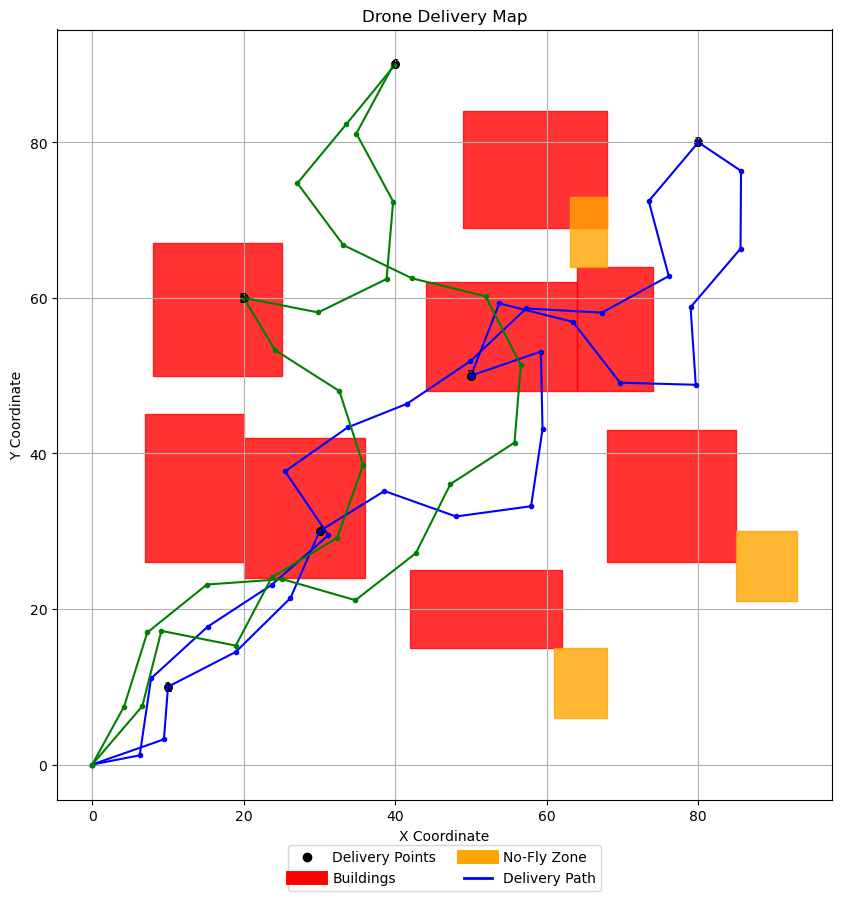

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib.lines import Line2D

# Parameters
map_size = (100, 100)
step_size = 10
max_iter = 200
weight_limit = 15
start = (0, 0)
delivery_points = [(10, 10), (50, 50), (80, 80), (30, 30), (20, 60), (40, 90)]  # x, y
weights = [3, 5, 2, 4, 3, 6]

# Check for overlap between buildings/no-fly zones
def check_overlap(rect1, rect2):
    (x1, y1), (a1, b1) = rect1  
    (x2, y2), (a2, b2) = rect2  
    return not (a1 <= x2 or x1 >= a2 or b1 <= y2 or y1 >= b2)


# Generate randomized map
def generate_random_map(map_size, num_buildings=8, num_no_fly_zones=3):
    buildings = []
    no_fly_zones = []

    for _ in range(num_buildings):
        while True:
            x1, y1 = random.randint(5, map_size[0] - 20), random.randint(5, map_size[1] - 20)
            x2, y2 = x1 + random.randint(10, 20), y1 + random.randint(10, 20)
            building = ((x1, y1), (x2, y2))
            if not any(check_overlap(building, b) for b in buildings):
                buildings.append(building)
                break

    for _ in range(num_no_fly_zones):
        while True:
            x1, y1 = random.randint(5, map_size[0] - 15), random.randint(5, map_size[1] - 15)
            x2, y2 = x1 + random.randint(5, 10), y1 + random.randint(5, 10)
            no_fly_zone = ((x1, y1), (x2, y2))
            if not any(check_overlap(no_fly_zone, z) for z in no_fly_zones):
                no_fly_zones.append(no_fly_zone)
                break

    return buildings, no_fly_zones

def distance(p1, p2):# Used to calculate distance
    return np.linalg.norm(np.array(p1) - np.array(p2))

def is_collision_free(p1, p2, no_fly_zones, buffer_distance=1):
    
    p1, p2 = np.array(p1), np.array(p2)
    
    for (x1, y1), (x2, y2) in no_fly_zones:
        # New No-Fly Zone Boundaries
        x1, y1 = x1 - buffer_distance, y1 - buffer_distance
        x2, y2 = x2 + buffer_distance, y2 + buffer_distance
        
        # Check if either point (p1 or p2) is inside the no-fly zone
        if (x1 < p1[0] < x2 and y1 < p1[1] < y2) or (x1 < p2[0] < x2 and y1 < p2[1] < y2):
            return False

        # Check if the line between p1 and p2 intersects the no-fly zone
        if (min(p1[0], p2[0]) <= x2 and max(p1[0], p2[0]) >= x1 and
            min(p1[1], p2[1]) <= y2 and max(p1[1], p2[1] ) >= y1):
            return False

    return True

# RRT* Algorithm
class RRTStar:
    def __init__(self, start, goal, no_fly_zones, step_size, max_iter, radius=15):
        self.start = start
        self.goal = goal
        self.no_fly_zones = no_fly_zones
        self.step_size = step_size
        self.max_iter = max_iter
        self.radius = radius
        self.tree = {start: None}
        self.costs = {start: 0}  # Cost to reach each node

    # Extend the tree to a new random point
    def extend_tree(self, random_point):
        nearest_node = min(self.tree.keys(), key=lambda n: distance(n, random_point))
        direction = np.array(random_point) - np.array(nearest_node)
        length = np.linalg.norm(direction)
        if length == 0:
            return None
        new_node = tuple(np.array(nearest_node) + self.step_size * direction / length)
        if  not is_collision_free(nearest_node, new_node, self.no_fly_zones):
            return None
        # Add new node to the tree
        self.tree[new_node] = nearest_node
        self.costs[new_node] = self.costs[nearest_node] + distance(nearest_node, new_node)
        self.rewire_tree(new_node)  # Perform rewiring
        return new_node

    # Check if a point is within the map boundaries
    def is_within_bounds(self, point):
        return 0 <= point[0] < map_size[0] and 0 <= point[1] < map_size[1]

    # Find nearby nodes within a given radius and rewire the tree
    def rewire_tree(self, new_node):
        for node in self.tree.keys():
            if node == new_node:
                continue
            if distance(node, new_node) < self.radius and is_collision_free(new_node, node, self.no_fly_zones):
                new_cost = self.costs[new_node] + distance(new_node, node)
                if new_cost < self.costs[node]:  # Check if the path is shorter
                    self.tree[node] = new_node
                    self.costs[node] = new_cost

    # Find the optimal path
    def find_path(self):
        for _ in range(self.max_iter):
            random_point = (random.uniform(0, map_size[0]), random.uniform(0, map_size[1]))
            new_node = self.extend_tree(random_point)
            if new_node and distance(new_node, self.goal) < self.step_size:
                if is_collision_free(new_node, self.goal, self.no_fly_zones):
                    self.tree[self.goal] = new_node
                    self.costs[self.goal] = self.costs[new_node] + distance(new_node, self.goal)
                    return self.reconstruct_path()
        return None

    # Reconstruct the path from goal to start
    def reconstruct_path(self):
        path = []
        node = self.goal
        while node is not None:
            path.append(node)
            node = self.tree.get(node)
        return path[::-1]

def deliver_packages():
    buildings, no_fly_zones = generate_random_map(map_size)
    remaining_points = list(zip(delivery_points, weights))
    paths = []
    round_number = 1
    total_distance = 0  

    while remaining_points:
        print(f"\nStarting Round {round_number}...")
        current_load = 0
        round_points = []
        # Select packages for the current round
        for i, (point, weight) in enumerate(remaining_points):
            if current_load + weight <= weight_limit:
                current_load += weight
                round_points.append((point, weight))
        # Remove selected packages from remaining_points
        remaining_points = [p for p in remaining_points if p not in round_points]

        round_paths = []
        current_position = start 
        round_points = sorted(round_points, key=lambda p: distance(current_position, p[0])) #To sort the points in that round 
        for point, weight in round_points:
            print(f"Delivering to {point} (Weight: {weight}kg)...")
            rrt_star = RRTStar(current_position, point, no_fly_zones, step_size, max_iter)
            path = rrt_star.find_path()
            if path:
                round_paths.append(path)
                current_position = point  # Update current position
                distance_covered = distance(path[0], path[-1])  
                total_distance += distance_covered  
                print(f"Path to {point} found. Distance covered: {distance_covered:.2f} units.")
            else:
                print(f"No valid path to {point}. Skipping delivery.")
        
        # Return to base after completing all deliveries in the round
        rrt_star = RRTStar(current_position, start, no_fly_zones, step_size, max_iter)
        return_path = rrt_star.find_path()
        while not return_path:
            return_path = rrt_star.find_path()
        
        round_paths.append(return_path)
        return_distance = distance(return_path[0], return_path[-1])  # Distance for return path
        total_distance += return_distance  
        print(f"Return path to base found. Distance covered: {return_distance:.2f} units.")
        paths.append(round_paths)
        round_number += 1

    print(f"\nTotal distance covered: {total_distance:.2f} units.")  # Display total distance
    return buildings, no_fly_zones, paths

# Plot Results
def plot_results(buildings, no_fly_zones, paths):
    plt.figure(figsize=(10, 10))
    for (x1, y1), (x2, y2) in buildings:
        plt.fill([x1, x2, x2, x1], [y1, y1, y2, y2], color='red', alpha=0.8)
    for (x1, y1), (x2, y2) in no_fly_zones:
        plt.fill([x1, x2, x2, x1], [y1, y1, y2, y2], color='orange', alpha=0.8)
    colors = ['blue', 'green', 'purple', 'brown', 'cyan']
    for i, round_paths in enumerate(paths):
        color = colors[i % len(colors)]
        for path in round_paths:
            x, y = zip(*path)
            plt.plot(x, y, marker='o', markersize=3, color=color)
    
    # Mark delivery points
    for idx, point in enumerate(delivery_points):
        plt.text(point[0], point[1], f'{idx+1}', color='black', fontsize=10, ha='center', va='center')
        plt.scatter(point[0], point[1], color='black', s=30)

    # Add legend
    legend_elements = [
        Line2D([0], [0], color='black', marker='o', markersize=6, linestyle='None', label='Delivery Points'),
        Line2D([0], [0], color='red', lw=10, label='Buildings'),
        Line2D([0], [0], color='orange', lw=10, label='No-Fly Zone'),
        Line2D([0], [0], color='blue', lw=2, label='Delivery Path')
    ]
    plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)

    plt.title("Drone Delivery Map")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.grid(True)
    plt.show()

# Main execution
buildings, no_fly_zones, paths = deliver_packages()
plot_results(buildings, no_fly_zones, paths)
